# Problématique

Trouver la distribution maximal de flot dans un graphe.

## Exercice 

Résoudre avec `networkx` le problème de flot maximal associé au graphe

```dot
A -> B [label=1];
A -> C [label=4];
B -> C [label=3];
B -> D [label=2];
C -> D [label=1]
```

La source étant $A$ et la destination $D$ on a donc des quantités transportées 
- $x$ sur `A -> B`
- $y$ sur `A -> C`
- $z$ sur `B -> C`
- $u$ sur `C -> D`
- $v$ sur `B -> D`

Et on a donc les contraintes de  capacités:
$$
\begin{cases}
0\leq x \leq 1\\
0\leq y \leq 4\\
0\leq z \leq 3\\
0\leq u \leq 1\\
0\leq v \leq 2\\
\end{cases}.
$$
On a aussi les contraintes de conservation aux sommets qui ne sont pas source/destination:

\begin{align}
x & =  z+v & \text{ en } B,\\
y + z & = u & \text{ en } C,
\end{align}
En conséquence on peut montrer $ x+y = u+v$ (ce qui sort de la source et égal à ce qui arrive à la destination)

On cherche donc finalement à maximiser la quantité $u+v$.

In [1]:
import networkx as nx

In [2]:
import numpy as np

In [3]:
graphe = nx.DiGraph()
graphe.add_nodes_from(list("ABCD"))
graphe.add_edges_from(
    [
        ("A", "B", {"capacite": 1}),
        ("A", "C", {"capacite": 4}),
        ("B", "C", {"capacite": 3}),
        ("B", "D", {"capacite": 2}),
        ("C", "D", {"capacite": 1}),
    ]
)

## Exercice 

Modifier l'affichage pour ne pas avoir de croisement d'arrêtes et de voir les capacités des arrêtes.

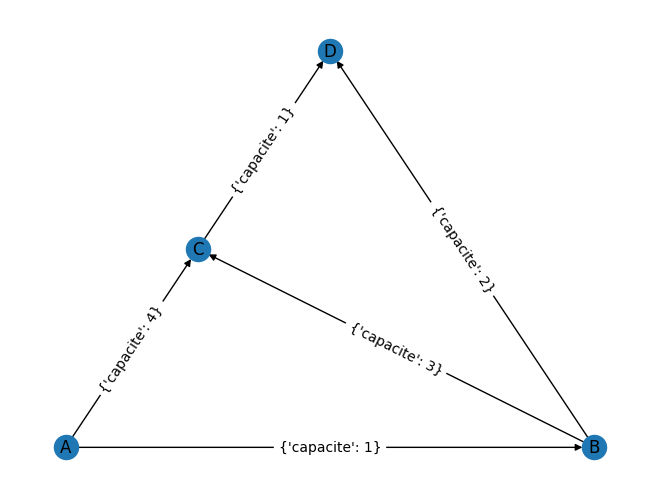

In [4]:
positions = nx.layout.planar_layout(graphe)
nx.draw(graphe, pos=positions)
nx.draw_networkx_labels(graphe, pos=positions)
nx.draw_networkx_edge_labels(graphe, pos=positions);

In [5]:
print(positions)

{'A': array([-0.77777778, -0.33333333]), 'B': array([ 1.        , -0.33333333]), 'C': array([-0.33333333,  0.11111111]), 'D': array([0.11111111, 0.55555556])}


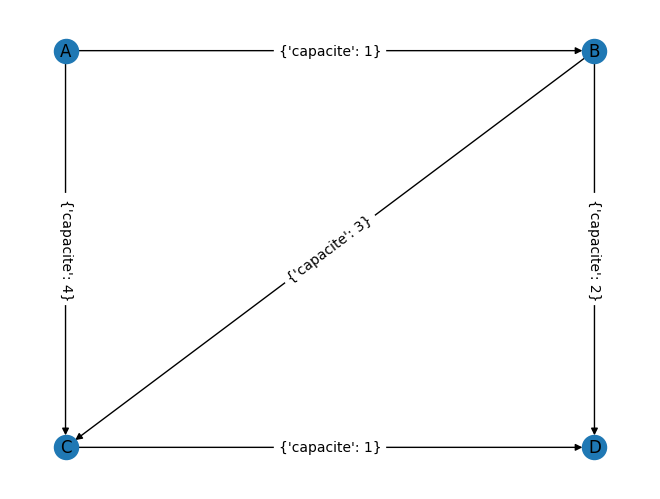

In [6]:
# placement manuel
positions=dict(
    A=np.array([0,1]),
    B=np.array([1,1]),
    C=np.array([0,0]),
    D=np.array([1,0]),
)
nx.draw(graphe, pos=positions)
nx.draw_networkx_labels(graphe, pos=positions)
nx.draw_networkx_edge_labels(graphe, pos=positions);

In [7]:
val, rep = nx.maximum_flow(graphe, "A", "D", capacity="capacite")

In [8]:
val

2

In [9]:
rep

{'A': {'B': 1, 'C': 1}, 'B': {'C': 0, 'D': 1}, 'C': {'D': 1}, 'D': {}}

## Exercice

Visualiser le flot maximal sur la figure précédente

In [10]:
nouveau = graphe.copy()

In [11]:
for depart, voisinage  in rep.items():
    for arrivee, flot in voisinage.items():
        nouveau[depart][arrivee]["flot"] = flot

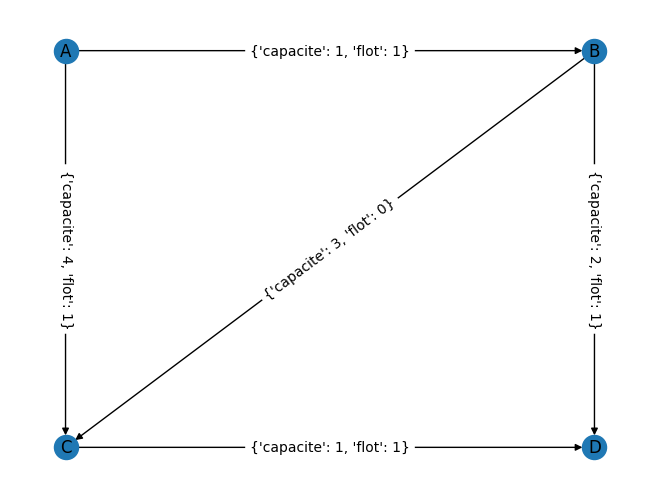

In [12]:
positions=dict(
    A=np.array([0,1]),
    B=np.array([1,1]),
    C=np.array([0,0]),
    D=np.array([1,0]),
)
nx.draw(nouveau, pos=positions)
nx.draw_networkx_labels(nouveau, pos=positions)
nx.draw_networkx_edge_labels(nouveau, pos=positions);

## Exercice

On a un budget de 5 pour modifier les capacités.
Quelle est la meilleure façons de répartir ses améliorations?

In [13]:
def calcule(ab=0, ac=0, bc=0, bd=0, cd=0):
    
    graphe = nx.DiGraph()
    graphe.add_nodes_from(list("ABCD"))
    graphe.add_edges_from(
        [
            ("A", "B", {"capacite": 1+ab}),
            ("A", "C", {"capacite": 4+ac}),
            ("B", "C", {"capacite": 3+bc}),
            ("B", "D", {"capacite": 2+bd}),
            ("C", "D", {"capacite": 1+cd}),
        ]
    )
    valeur, repartition = nx.maximum_flow(graphe, "A", "D", capacity="capacite")
    return valeur

In [14]:
calcule()

2

In [15]:
calcule(ab=1)

3

In [16]:
calcule(ab=2)

3

In [17]:
calcule(ab=1, cd=1)

4

In [18]:
calcule(ab=1, cd=2)

5

In [19]:
calcule(ab=1, cd=3)

6

In [20]:
calcule(ab=1, cd=4)

6

**Remarque** Ce problème peut de nouveau être codé en terme de programmation linéaire.

On appelle
- $\alpha$ l'augmentation de capacité de `A -> B`
- $\beta$ l'augmentation de capacité de `A -> C`
- $\gamma$ l'augmentation de capacité de `B -> C`
- $\epsilon$ l'augmentation de capacité de `B -> D`
- $\delta$ l'augmentation de capacité de `C -> D`

On a alors le système de contraintes.
$$
\begin{cases}
0\leq x \leq 1 + \alpha\\
0\leq y \leq 4 + \beta\\
0\leq z \leq 3 + \gamma\\
0\leq u \leq 1 + \delta\\
0\leq v \leq 2 + \epsilon\\
0\leq \alpha\\
0\leq \beta\\
0\leq \gamma\\
0\leq \delta\\
0\leq \epsilon\\
\alpha + \beta + \gamma + \delta + \epsilon \leq 5\\
x = z + v\\
y + z = u\\
\end{cases}
$$
et on cherche à maximiser $ u+v$.

On peut alors coder le problème via `scipy.optimize.linprog`.

On va utiliser le vecteur $X=(x, y, z, u, v, \alpha, \beta, \gamma, \delta, \epsilon)$

on va utiliser $l=(0,0,0,0,0,0,0,0,0,0)$,  

\begin{equation}
A_{eq}=\begin{pmatrix}
1 & 0 &  -1 & 0 & -1 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 1 & -1 & 0 & 0 & 0 & 0 & 0 & 0 
\end{pmatrix}\qquad b_{eq}=\begin{pmatrix} 0 \\ 0\end{pmatrix}
\end{equation}
\begin{equation}
A_{ub}=\begin{pmatrix}
1 & 0 & 0 & 0 & 0 & -1  & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0  & 0 & -1 & 0 & 0\\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & -1 & 0\\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & -1\\
0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1
\end{pmatrix}\qquad b_{ub}=\begin{pmatrix} 1 \\ 4 \\ 3 \\ 1\\ 2 \\ 5 \end{pmatrix}
\end{equation}

$$
c = 
\begin{pmatrix}
0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0
\end{pmatrix}
$$

In [23]:
from scipy.optimize import linprog

In [29]:
bounds = [(0, None) for _ in range(10)]
b_eq = np.zeros(2)
b_ub = np.array([1, 4, 3, 1, 2, 5])
c = np.array([0, 0, 0, -1 , -1, 0, 0, 0, 0, 0])
A_eq = np.array(
    [
        [1, 0, -1, 0, -1, 0, 0, 0, 0, 0], 
        [0, 1, 1, -1, 0, 0, 0, 0, 0, 0]
    ]
)
A_ub = np.array(
    [
        [1, 0, 0, 0, 0, -1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, -1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, -1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, -1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, -1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    ]
)

In [30]:
resultat = linprog(c, A_ub, b_ub, A_eq, b_eq, bounds, )

In [31]:
resultat

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -6.5
              x: [ 2.000e+00  4.500e+00  0.000e+00  4.500e+00  2.000e+00
                   1.000e+00  5.000e-01  0.000e+00  3.500e+00  0.000e+00]
            nit: 8
          lower:  residual: [ 2.000e+00  4.500e+00  0.000e+00  4.500e+00
                              2.000e+00  1.000e+00  5.000e-01  0.000e+00
                              3.500e+00  0.000e+00]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              0.000e+00  0.000e+00  0.000e+00  5.000e-01
                              0.000e+00  0.000e+00]
          upper:  residual: [       inf        inf        inf        inf
                                    inf        inf        inf        inf
                                    inf        inf]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                       

In [32]:
resultat.x

array([2. , 4.5, 0. , 4.5, 2. , 1. , 0.5, 0. , 3.5, 0. ])

In [33]:
linprog(c, A_ub, b_ub, A_eq, b_eq, bounds, method="simplex")

C:\Users\perrollaz\AppData\Local\Temp\ipykernel_11068\4030752852.py:1: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  linprog(c, A_ub, b_ub, A_eq, b_eq, bounds, method="simplex")


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -6.5
       x: [ 2.500e+00  4.000e+00  5.000e-01  4.500e+00  2.000e+00
            1.500e+00  0.000e+00  0.000e+00  3.500e+00  0.000e+00]
     nit: 9

## Exercice

Injecter la solution calculée par programmation linéaire dans le graphe pour visualiser le résultat.